In [4]:
#Import#

from cellpose import models, core, io, plot
from cellpose import train
from cellpose import metrics
import numpy as np
from pathlib import Path
from tqdm import trange
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
import skimage.filters
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage import exposure
from skimage.measure import regionprops
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from scipy import ndimage as ndi
from skimage import img_as_float
from skimage.filters import sobel
from scipy.spatial.distance import cdist
from scipy.ndimage import generate_binary_structure, binary_dilation
import pandas as pd
from glob import glob
import cv2


import time

In [5]:
#Data input from the User

folder_path = r'Y:\Group Members\Valentin Aubry\01_Data\Data_Andreas_single'  # The r in r'Example' is very important


# Check if the folder is empty or even exists
if os.path.isdir(folder_path) == True:
    print("Folder Path exists")

    # Getting the list of directories
    dir = os.listdir(folder_path)
    
    # Checking if the list is empty or not
    if len(dir) == 0:
        print("Empty directory")
    else:
        print("Not empty directory")
else:
    print("Folder path not found")

Folder Path exists
Not empty directory


In [56]:



# High Throughput Data Loading
Cy5_data = glob(os.path.join(folder_path, '*Cy5 SEM.tif'))
DAPI_data = glob(os.path.join(folder_path, '*DAPI SEM.tif'))
DAPI_mask_data = glob(os.path.join(folder_path, '*DAPI SEM_seg.npy'))
FITC_data = glob(os.path.join(folder_path, '*FITC SEM.tif'))
TRITC_data = glob(os.path.join(folder_path, '*TRITC SEM.tif'))


# Sorting the data in case it isn't yet
Cy5_data.sort()
DAPI_data.sort()
DAPI_mask_data.sort()
FITC_data.sort()
TRITC_data.sort()


# Displaying all the data that was loaded
for i in range (len(DAPI_data)):
    print(os.path.basename(Cy5_data[i]))
    print(os.path.basename(DAPI_data[i]))
    print(os.path.basename(DAPI_mask_data[i]))
    print(os.path.basename(FITC_data[i]))
    print(os.path.basename(TRITC_data[i]))



# Function to check if a potential foci is X-times brighter than the immediate Background (preventing false positives)
def local_contrast(image, coordinates, bright_percentage, contrast_threshold=2.5):
    confirmed_coords = []  #Empty array to store the filtered coordinates in later
    for i in coordinates:
        y, x = i   # Get the coordinates for each foci 
        y_min, y_max = max(0, y-5), min(image.shape[0], y+6)  #setting boudaries from y-5 to y+5(Y+6 gets excluded as upper border)
        x_min, x_max = max(0, x-5), min(image.shape[1], x+6)
        square = image[y_min:y_max, x_min:x_max]  #creating a square with the defined boudaries

        potential_foci = image[y, x]
        local_background = np.percentile(square, bright_percentage)  # Selects a pixel with the brightness in the defined percentage for comparison

        if potential_foci > local_background * contrast_threshold:  # If the potential foci is X-times brighter than the selected background, the foci is confirmed
            confirmed_coords.append(i)
            
    # returns the confirmed foci coordinates or if there are none creates an empty array to not crash the display below
    return np.array(confirmed_coords) if confirmed_coords else np.array([]).reshape(0, 2)

ATR2_24h--W00044--P00021--Z00000--T00000--Cy5 SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--DAPI SEM_seg.npy
ATR2_24h--W00044--P00021--Z00000--T00000--FITC SEM.tif
ATR2_24h--W00044--P00021--Z00000--T00000--TRITC SEM.tif


In [ ]:
#timer to measure how long it takes
start_time = time.time()


#High Throughput Data Loading Loop
for i in range (len(DAPI_data)):
#for i in range (1):
    #Loading the picture on i position from each channel
    Cy5_pic = imageio.imread(Cy5_data[i])
    DAPI_pic = imageio.imread(DAPI_data[i])
    DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
    FITC_pic = imageio.imread(FITC_data[i])
    TRITC_pic = imageio.imread(TRITC_data[i])

    # Extract the name of the picture that will be analyzed to later be able to save it accordingly
    base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

    # Converting the TRITC picture to float to make sure that all the pixel values are compatible with eachother
    TRITC_pic = img_as_float(TRITC_pic)

    # Extract the actual mask array
    masks = DAPI_mask_pic['masks']  # This contains the segmented regions
    
    # Gets the brightness of the 99th percentile of brightest pixels to reduce outliers
    almost_max = np.percentile(TRITC_pic[TRITC_pic > 0], 99) 

    # Parameters for the foci search in the picture with the difference of gaussian filter
    foci_distance_filt = 2  # Foci have to have this distance between themselves to be able to be detected
    foci_threshold_filt = almost_max * 0.8  # Pixels need to be at least as bright as the defined fraction of the brightes pixel in the picture
    
    # Parameters for the foci search in the picture without any filter
    foci_distance_unfilt = 2  # Foci have to have this distance between themselves to be able to be detected
    foci_threshold_unfilt = almost_max * 0.8  # Pixels need to be at least as bright as the defined fraction of the brightes pixel in the picture
    
    tolerance = 2  # Distance at which the detected foci in the gamma adjusted TRIC picture are confirmed if there is one also detected on the DoG picture



    # Function to go through every cell individually that cellpose recognized
    for j in range (1,len(np.unique(masks))):
    #for j in range (1,6):
        
        # Defining which nucleus from the Segmentation Mask is isolated
        cellnumber = j
        masks_reduced = (masks == cellnumber)  
    
        # Overlaying DAPI mask to TRITC
        masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  
    
        # Applying the mask to the TRITC picture by setting the background to 0 (black)
        isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
        isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)
        
        # Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
        filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, low_sigma=1, high_sigma=2, mode='nearest', cval=0, channel_axis=None, truncate=4.0)
        filtered_TRITC = np.clip(filtered_TRITC, 0, None)  # This just ensures that the pixels don't have negative value (0 = Black)

        # Changing the pixel brightness values of the filtered picture so that they are in the same range like the unfiltered one 
        filtered_TRITC = exposure.rescale_intensity(filtered_TRITC, in_range='image', out_range=(0, isolated_TRITC.max()))

        # Detecting the coordinates of the ptential foci in the unfiltered picture
        coordinates_filtered = peak_local_max(
            filtered_TRITC, 
            min_distance=foci_distance_filt,        # This is just the minimal distance of how close two foci can be detected next to eachother
            threshold_abs=foci_threshold_filt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
        )
        
        # Detecting the coordinates of the potential foci in the filtered picture
        coordinates_unfiltered = peak_local_max(
            isolated_TRITC, 
            min_distance=foci_distance_unfilt,        # This is just the minimal distance of how close two foci can be detected next to eachother
            threshold_abs=foci_threshold_unfilt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
        )

        # Checking if the detected foci are brighter than their immediate background
        coordinates_unfiltered = local_contrast(isolated_TRITC, coordinates_unfiltered, 50, contrast_threshold=1.5)
        coordinates_filtered = local_contrast(filtered_TRITC, coordinates_filtered, 25)

        # Confirm foci detected in the undfiltered picture if they were also detected in the filtered one (within tolerance distance)
        distances = cdist(coordinates_unfiltered, coordinates_filtered)  # calculate the distance between filtered foci and unfiltered foci
        tolerance = tolerance  # pixels of how far apart the foci maximally can be on both pictures to be confirmed

        if coordinates_unfiltered.size > 0 and coordinates_filtered.size > 0:
            # Keep foci from unfiltered that have a match in filtered
            coordinates = coordinates_unfiltered[np.min(distances, axis=1) <= tolerance]  # np.min: find minimal distance between nearest foci, 
            #<=tolerance: creates a boolean array with true for each unfiltered foci with a filtered one within tolerance, 
            #coordinates_unfiltered[]: keeps only foci that are True
        else:
            coordinates = np.array([]).reshape(0, 2)  #generating an epmty array, so that the visualization down below doesn't get an error if no foci was detected

        #Creating a datafreame containing all the coordinates of foci labbeled with each cell
        foci_data = pd.DataFrame(data=coordinates, columns=['y', 'x'])
        foci_data['cell_number'] = cellnumber

        
        # Setting up threshold for the watershed segmentation
        water_threshold = foci_threshold_filt

        # Setting up the parameters for the waterhsed segmentation
        markers = np.zeros_like(filtered_TRITC, dtype=int)  # creates an array with the same shape and size as isolated_TRITC but all zeros
        for i, (y, x) in enumerate(coordinates, start=1):  
            markers[y, x] = i  # gives the previously created zero array a number at the point of the foci coordinates
      
        # To keep all the individual foci when expanding, they are expanded individually
        markers_expanded = np.zeros_like(filtered_TRITC, dtype=int)
        for k in range (markers.max()):
            label = k + 1
            single_marker = (markers == label)
            markers_dilated = ndi.binary_dilation(single_marker, iterations=1) #  dilates the foci spots for X iterations
            markers_expanded[markers_dilated] = label  
    
        # One of these is needed to create a boundary for the watershed segmentation
        distance = ndi.distance_transform_edt(filtered_TRITC < water_threshold)  # calculates Distance to the nearest background
        gradient = sobel(filtered_TRITC)  # Is used to create "ridges" at the border between foci and background
        
        # Ensure all marker positions are included in the mask
        watershed_mask = (filtered_TRITC > water_threshold) | (markers_expanded > 0)
        # Creates a mask that contains all the pixels that would get segmented in the watershed and the pixel that was detected as the center of the foci
        water_labels = watershed(gradient, markers_expanded, mask=watershed_mask)  # Applying Watershed, -distance to invert map height map (to make peaks to valleys)
        # The watershed was now done within the borders of the previously defined mask

        # Create empty columns to later add the data to (like this the rows will also exist if no data is added to it)
        foci_data['foci_area'] = 0
        foci_data['foci_intensity'] = 0.0  
        
        # looping through all the coordinates of the previously detected foci by giving each coordinate pair additionally a number (idx contains number and variables y,x contain location)
        for idx, (y, x) in enumerate(coordinates):
            
            region_id = water_labels[y, x]   # Gets the segmented region that contains the y,x coordinates
            
            # Get the data for the specific region that contains the pixel y,x
            spot_mask = (water_labels == region_id)
            spot_area = np.sum(spot_mask)
            spot_intensity = np.sum(isolated_TRITC[spot_mask])

            # Assign data to the correct row that was previously created
            foci_data.loc[idx, 'foci_area'] = spot_area
            foci_data.loc[idx, 'foci_intensity'] = spot_intensity

      
        # Preparing arguments for saving the data in a .csv
        header = False # So it doesn't add a header unless j=1
        mode = 'a'  # so it adds to an existing file that was created with the first analyzed cell at j=1
        
        if j == 1:
            header = True  # To add a header when creating the file
            mode = 'a'  # Standard mode (not adding to a file)
            # Adding the information for what seperates the data for excel     
            with open(folder_path+'/'+base_name+'DF SEM.csv', 'w') as f:  # Write 'sep=,' as the very first line
                f.write('sep=,\n')


        #Actual saving part
        foci_data.to_csv(folder_path+'/'+base_name+'DF SEM.csv', mode=mode, header=header, index=False)

#####################################################################################################
# Display of the number of Foci on the cells

# Count foci per cell from your saved data or during processing
# If you have foci_data available at this point in your loop:
foci_counts = foci_data.groupby('cell_number').size().to_dict()

# Adding foci counts to the Individual nuclei
nums = regionprops(masks)
for prop in nums:
    # Getting the coordinates of the center of the nuclei
    y, x = prop.centroid
    label = prop.label
    
    # Get the foci count for this nucleus (default to 0 if none found)
    foci_count = foci_counts.get(label, 0)



# Plotting Masks
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(36, 24))

# Original DAPI Picture
axes.imshow(TRITC_pic)

# Adding numbers to the Individual nuclei to identify them easier
nums = regionprops(masks)
for prop in nums:
    #Getting the coordinates of the center of the nuclei
    y, x = prop.centroid  # getting the x and y coordinates
    label = prop.label   # getting the number of the nucleus at that position

    # Adding the text at the location of the centroids
    axes.text(x, y, str(foci_count), color = 'red', fontsize = 14, ha = 'center', va = 'center', weight = 'bold')

axes.axis('off')
axes.set_title('DAPI', fontsize = 40)



##############################################################################################################













end_time = time.time()
elapsed_time = end_time - start_time

# Convert to minutes and seconds for easier reading
minutes = int(elapsed_time // 60)
seconds = elapsed_time % 60

print(f"Total runtime: {minutes} minutes and {seconds:.2f} seconds")

'''
One Picture Runtime:
- 5min 31sec


'''

In [57]:
print(coordinates)

[[912 297]
 [926 311]
 [878 291]
 [864 308]
 [901 304]
 [889 285]
 [923 336]
 [876 351]]


In [147]:
print(os.path.basename(TRITC_data[5]))

ATR2_UT--W00038--P00017--Z00000--T00000--TRITC SEM.tif


In [ ]:
# 5--> 58, 75, 93, 37

In [48]:
print(len(np.unique(masks)))

142


In [49]:
picture_number = 0
cell_number = 60


#High Throughput Data Loading Loop
#for i in range (len(DAPI_data)):
i = picture_number

#Loading the picture on i position from each channel
Cy5_pic = imageio.imread(Cy5_data[i])
DAPI_pic = imageio.imread(DAPI_data[i])
DAPI_mask_pic = np.load(DAPI_mask_data[i], allow_pickle=True).item()
FITC_pic = imageio.imread(FITC_data[i])
TRITC_pic = imageio.imread(TRITC_data[i])

TRITC_pic = img_as_float(TRITC_pic)




almost_max = np.percentile(TRITC_pic[TRITC_pic > 0], 99) # Gets the brightness of the 99th percentile of brightest pixels to reduce outliers

foci_distance_filt = 2
foci_threshold_filt = almost_max * 0.8

foci_distance_unfilt = 2
foci_threshold_unfilt = almost_max * 0.8

tolerance = 2  # Distance at which the detected foci in the gamma adjusted TRIC picture are confirmed if there is one also detected on the DoG picture




# Extract the name of the picture that will be analyzed to later be able to save it accordingly
base_name = os.path.basename(DAPI_data[i]).removesuffix('DAPI SEM.tif')

# Extract the actual mask array
masks = DAPI_mask_pic['masks']  # This contains the segmented regions

# Function to generate a picture for every cell that cellpose recognized
#for j in range (1,len(np.unique(masks))):
j = cell_number

# Defining which nucleus from the Segmentation Mask is isolated
cellnumber = j
masks_reduced = (masks == cellnumber)  

# Overlaying DAPI mask to TRITC
masked_TRITC = np.ma.masked_where(masks_reduced == 0, masks_reduced)  




# Applying the mask to the TRITC picture by setting the background to 0 (black)
isolated_TRITC = TRITC_pic.copy()  # copying the original picture so that it doesn't get changed
isolated_TRITC[masks_reduced==False] = 0  # assign the pixels from the TRITC picture copy the value 0 (black), where the mask has the value false (background)

#gamma_TRITC = skimage.exposure.adjust_gamma(isolated_TRITC, gamma=1)
#isolated_TRITC = exposure.rescale_intensity(isolated_TRITC, in_range='image', out_range=(0, isolated_TRITC.max()))


# Applying a difference of gaussian filter on the picture --> enhances peaks and smooths out background
filtered_TRITC = skimage.filters.difference_of_gaussians(isolated_TRITC, low_sigma=1, high_sigma=2, mode='nearest', cval=0, channel_axis=None, truncate=4.0)
filtered_TRITC = np.clip(filtered_TRITC, 0, None)

#filtered_TRITC = skimage.exposure.adjust_gamma(filtered_TRITC, gamma=1)
filtered_TRITC = exposure.rescale_intensity(filtered_TRITC, in_range='image', out_range=(0, isolated_TRITC.max()))


# Detecting the coordinates of the peaks in the unfiltered picture
coordinates_filtered = peak_local_max(
    filtered_TRITC, 
    min_distance=foci_distance_filt,        # This is just the minimal distance of how close two foci can be detected next to eachother
    threshold_abs=foci_threshold_filt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)

# Detecting the coordinates of the peaks in the filtered picture
coordinates_unfiltered = peak_local_max(
    isolated_TRITC, 
    min_distance=foci_distance_unfilt,        # This is just the minimal distance of how close two foci can be detected next to eachother
    threshold_abs=foci_threshold_unfilt       # Only peaks above X% of absolute brightest picture (not relative to the brightest pixel in the picture)
)

def local_contrast(image, coordinates, bright_percentage, contrast_threshold=2.5):
    confirmed_coords = []  #Empty array to store the filtered coordinates in later
    for i in coordinates:
        y, x = i   # Get the coordinates for each foci 
        y_min, y_max = max(0, y-5), min(image.shape[0], y+6)  #setting boudaries from y-5 to y+5(Y+6 gets excluded as upper border)
        x_min, x_max = max(0, x-5), min(image.shape[1], x+6)
        square = image[y_min:y_max, x_min:x_max]  #creating a square with the defined boudaries

        potential_foci = image[y, x]
        local_background = np.percentile(square, bright_percentage)  # Selects a pixel with the brightness in the defined percentage for comparison

        if potential_foci > local_background * contrast_threshold:  # If the potential foci is X-times brighter than the selected background, the foci is confirmed
            confirmed_coords.append(i)
            
    # returns the confirmed foci coordinates or if there are none creates an empty array to not crash the display below
    return np.array(confirmed_coords) if confirmed_coords else np.array([]).reshape(0, 2)
    
# Running the above defined function on the filtered and unfiltered coordinates
coordinates_unfiltered = local_contrast(isolated_TRITC, coordinates_unfiltered, 50, contrast_threshold=1.5)
coordinates_filtered = local_contrast(filtered_TRITC, coordinates_filtered, 25)


# Find foci that are close in both sets (within tolerance distance)
distances = cdist(coordinates_unfiltered, coordinates_filtered)  # calculate the distance between filtered foci and unfiltered foci
tolerance = tolerance  # pixels of how far apart the foci maximally can be on both pictures to be confirmed


if coordinates_unfiltered.size > 0 and coordinates_filtered.size > 0:
    # Keep foci from unfiltered that have a match in filtered
    coordinates = coordinates_unfiltered[np.min(distances, axis=1) <= tolerance]  # np.min: find minimal distance between nearest foci, 
    #<=tolerance: creates a boolean array with true for each unfiltered foci with a filtered one within tolerance, 
    #coordinates_unfiltered[]: keeps only foci that are True
else:
    coordinates = np.array([]).reshape(0, 2)  #generating an epmty array, so that the visualization down below doesn't get an error if no foci was detected






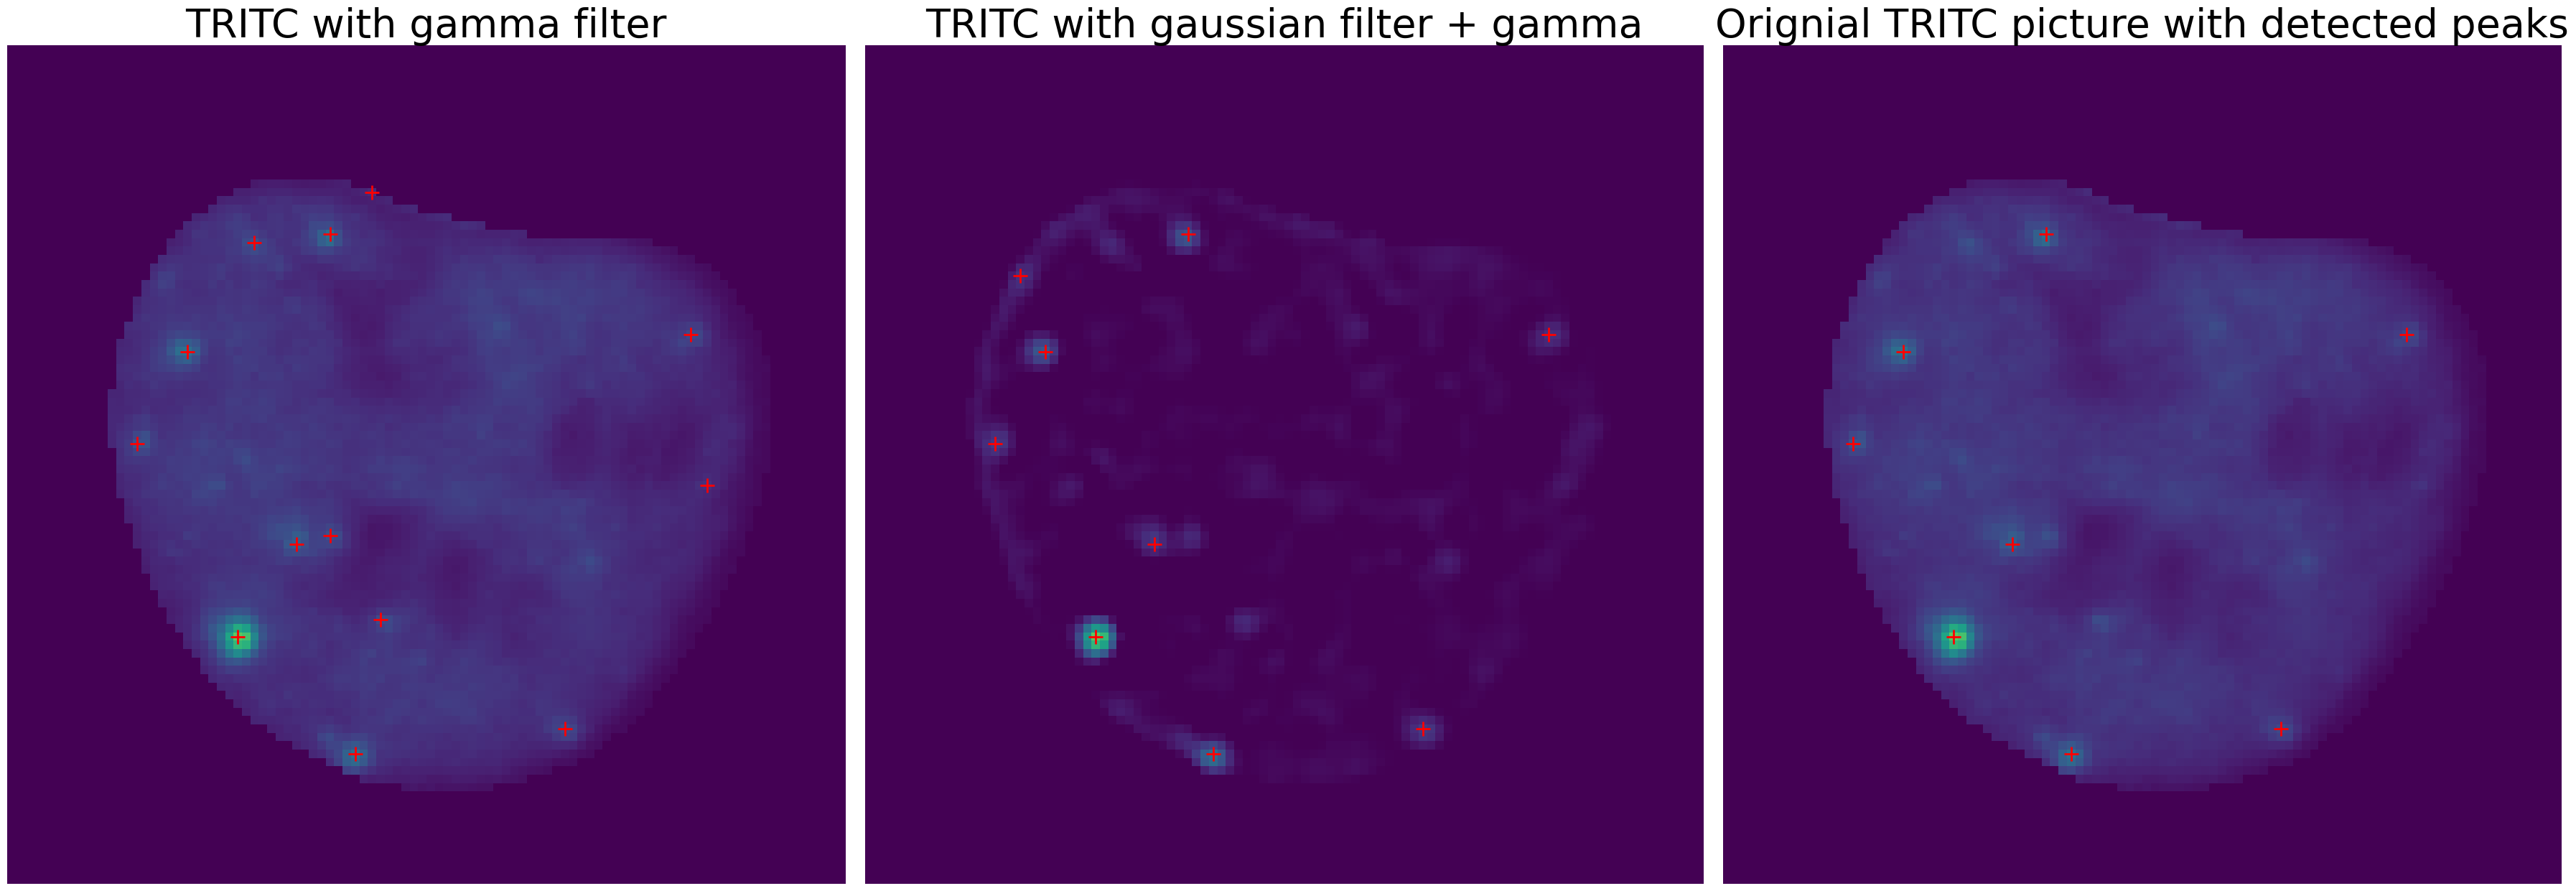

In [50]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(36, 12))

# Finding the middle coordinates for the cell we want to look at
props = regionprops(masks_reduced.astype(int))  # Calculate region properties (centroid, area, etc.) for the cell mask
if props:  # Check if any regions (props) were found in the mask
    centroid_y, centroid_x = props[0].centroid  # Extract y and x coordinates of the cell's center, which is the only region (props[0])

# To stop the possibility of going out of boundary
if int(centroid_y) < 50:
    centroid_y = 50
if int(centroid_x) < 50:
    centroid_x = 50

# Initial crop
origin = ((int(centroid_y)-50),(int(centroid_x)-50))
#origin = (0,0)
size = (100,100) #~100x100 for single cell
#size = (2048,2048)


# Original TRITC Picture with isolated cell
axes[0].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max())

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_unfiltered = coordinates_unfiltered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_unfiltered[:, 0] >= 0) & (adjusted_unfiltered[:, 0] < size[0]) & \
       (adjusted_unfiltered[:, 1] >= 0) & (adjusted_unfiltered[:, 1] < size[1])
visible_unfiltered = adjusted_unfiltered[mask]

# Plot the peaks
axes[0].plot(visible_unfiltered[:, 1], visible_unfiltered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[0].axis('off')
axes[0].set_title('TRITC with gamma filter', fontsize = 40)

# Filtered TRITC picture with isolated cell
axes[1].imshow(filtered_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max()) 

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_filtered = coordinates_filtered - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_filtered[:, 0] >= 0) & (adjusted_filtered[:, 0] < size[0]) & \
       (adjusted_filtered[:, 1] >= 0) & (adjusted_filtered[:, 1] < size[1])
visible_filtered = adjusted_filtered[mask]

# Plot the peaks
axes[1].plot(visible_filtered[:, 1], visible_filtered[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[1].axis('off')
axes[1].set_title('TRITC with gaussian filter + gamma', fontsize = 40)

# Original TRITC Picture with isolated cell
axes[2].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]], vmin=0, vmax=TRITC_pic.max())

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted_coords = coordinates - origin
# Filter to only show peaks within the cropped region
mask = (adjusted_coords[:, 0] >= 0) & (adjusted_coords[:, 0] < size[0]) & \
       (adjusted_coords[:, 1] >= 0) & (adjusted_coords[:, 1] < size[1])
visible_coords = adjusted_coords[mask]

# Plot the peaks
axes[2].plot(visible_coords[:, 1], visible_coords[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[2].axis('off')
axes[2].set_title('Orignial TRITC picture with detected peaks', fontsize = 40)

plt.tight_layout()
plt.show()

In [51]:
water_threshold = foci_threshold_filt

markers = np.zeros_like(filtered_TRITC, dtype=int)  # creates an array with the same shape and size as isolated_TRITC but all zeros
for i, (x, y) in enumerate(coordinates, start=1):  
    markers[x, y] = i  # gives the previously created zero array a number at the point of the foci coordinates

# To keep all the individual foci when expanding, they are expanded individually
markers_expanded = np.zeros_like(filtered_TRITC, dtype=int)
for i in range (markers.max()):
    label = i+1
    single_marker = (markers == label)
    markers_dilated = ndi.binary_dilation(single_marker, iterations=1) #  dilates the foci spots for X iterations
    markers_expanded[markers_dilated] = label  

# One of these 
distance = ndi.distance_transform_edt(filtered_TRITC < water_threshold)  # calculates Distance to the nearest background
gradient = sobel(filtered_TRITC)


# Ensure all marker positions are included in the mask
watershed_mask = (filtered_TRITC > water_threshold) | (markers_expanded > 0)
# Creates a mask that contains all the pixels that would get segmented in the watershed and the pixel that was detected as the center of the foci
water_labels = watershed(gradient, markers_expanded, mask=watershed_mask)  # Applying Watershed, -distance to invert map height map (to make peaks to valleys)
# The watershed was now done within the borders of the previously defined mask


# To get all the data from the watershed
for region_id in range(1, markers.max() + 1):
    spot_mask = (water_labels == region_id)
    spot_area = np.sum(spot_mask)
    spot_intensity = np.sum(isolated_TRITC[spot_mask])





<function matplotlib.pyplot.show(close=None, block=None)>

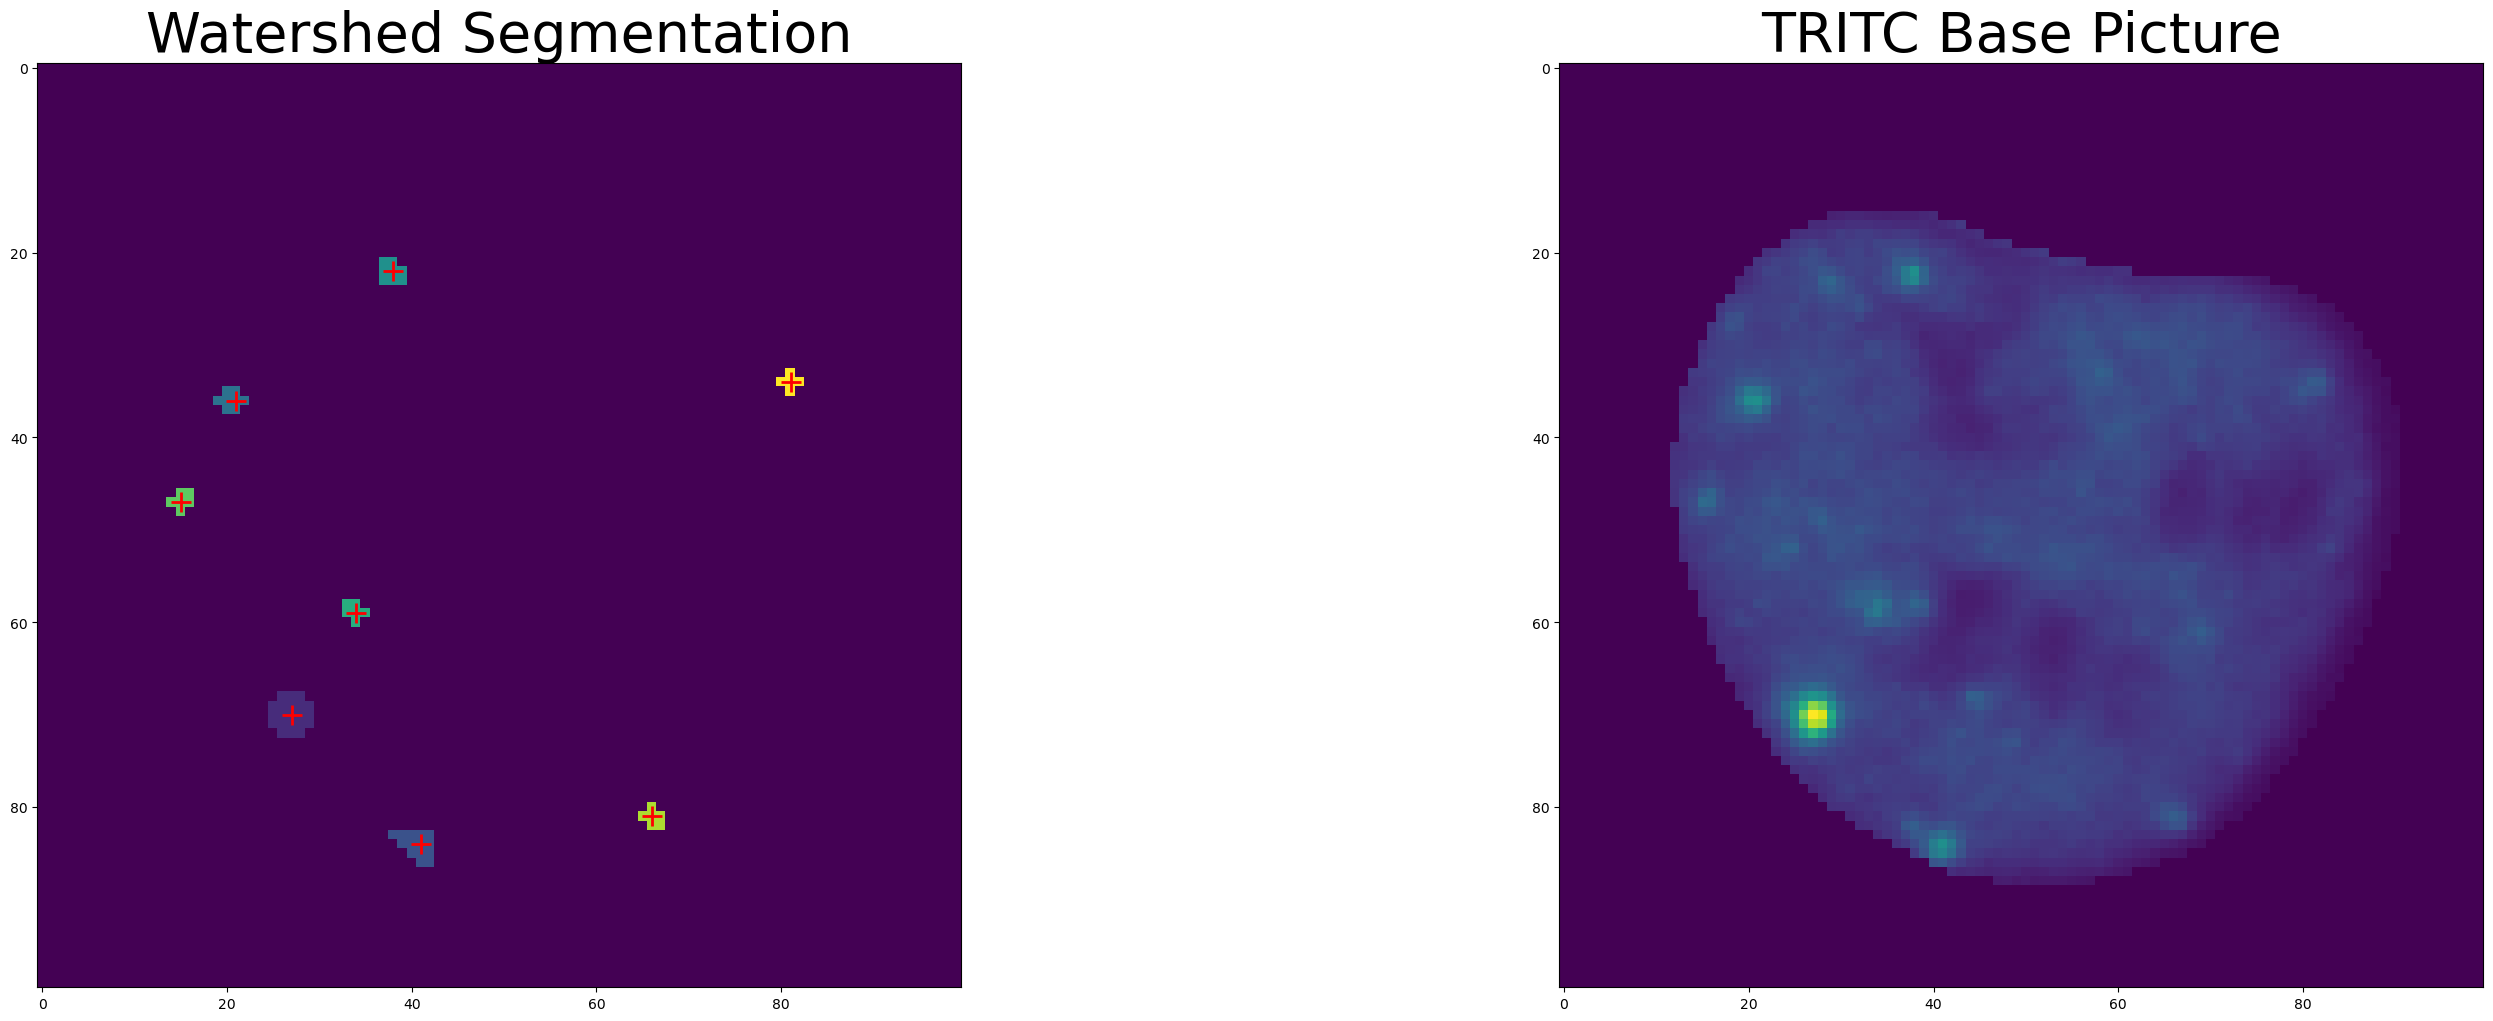

In [54]:
# Displaying the original picture with an isolated cell and the filtered picture
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(36, 12))

# Finding the middle coordinates for the cell we want to look at
props = regionprops(masks_reduced.astype(int))  # Calculate region properties (centroid, area, etc.) for the cell mask
if props:  # Check if any regions (props) were found in the mask
    centroid_y, centroid_x = props[0].centroid  # Extract y and x coordinates of the cell's center, which is the only region (props[0])

# To stop the possibility of going out of boundary
if int(centroid_y) < 50:
    centroid_y = 50
if int(centroid_x) < 50:
    centroid_x = 50

# Initial crop
origin = ((int(centroid_y)-50),(int(centroid_x)-50))
#origin = (0,0)
size = (100,100) #~100x100 for single cell
#size = (2048,2048)






# Show the watershed labels as colored regions
axes[0].imshow(water_labels[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])

####################### Made by AI ###################################
# Adjust coordinates relative to the cropped region
adjusted = coordinates - origin
# Filter to only show peaks within the cropped region
mask = (adjusted[:, 0] >= 0) & (adjusted[:, 0] < size[0]) & \
       (adjusted[:, 1] >= 0) & (adjusted[:, 1] < size[1])
visible = adjusted[mask]

# Plot the peaks
axes[0].plot(visible[:, 1], visible[:, 0], 'r+', 
             markersize=15, markeredgewidth=2)
#####################################################################

axes[0].set_title('Watershed Segmentation', fontsize = 40)


axes[1].imshow(isolated_TRITC[origin[0]:origin[0]+size[0],origin[1]:origin[1]+size[1]])
axes[1].set_title('TRITC Base Picture', fontsize = 40)

plt.show

In [53]:
spot_mask = (water_labels == region_id)
    spot_area = np.sum(spot_mask)
    spot_intensity = np.sum(isolated_TRITC[spot_mask])



IndentationError: unexpected indent (2074298438.py, line 2)

In [61]:
print(str(spot_mask))
print(str(spot_area))
print(str(spot_intensity))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
4
0.2622110322728313


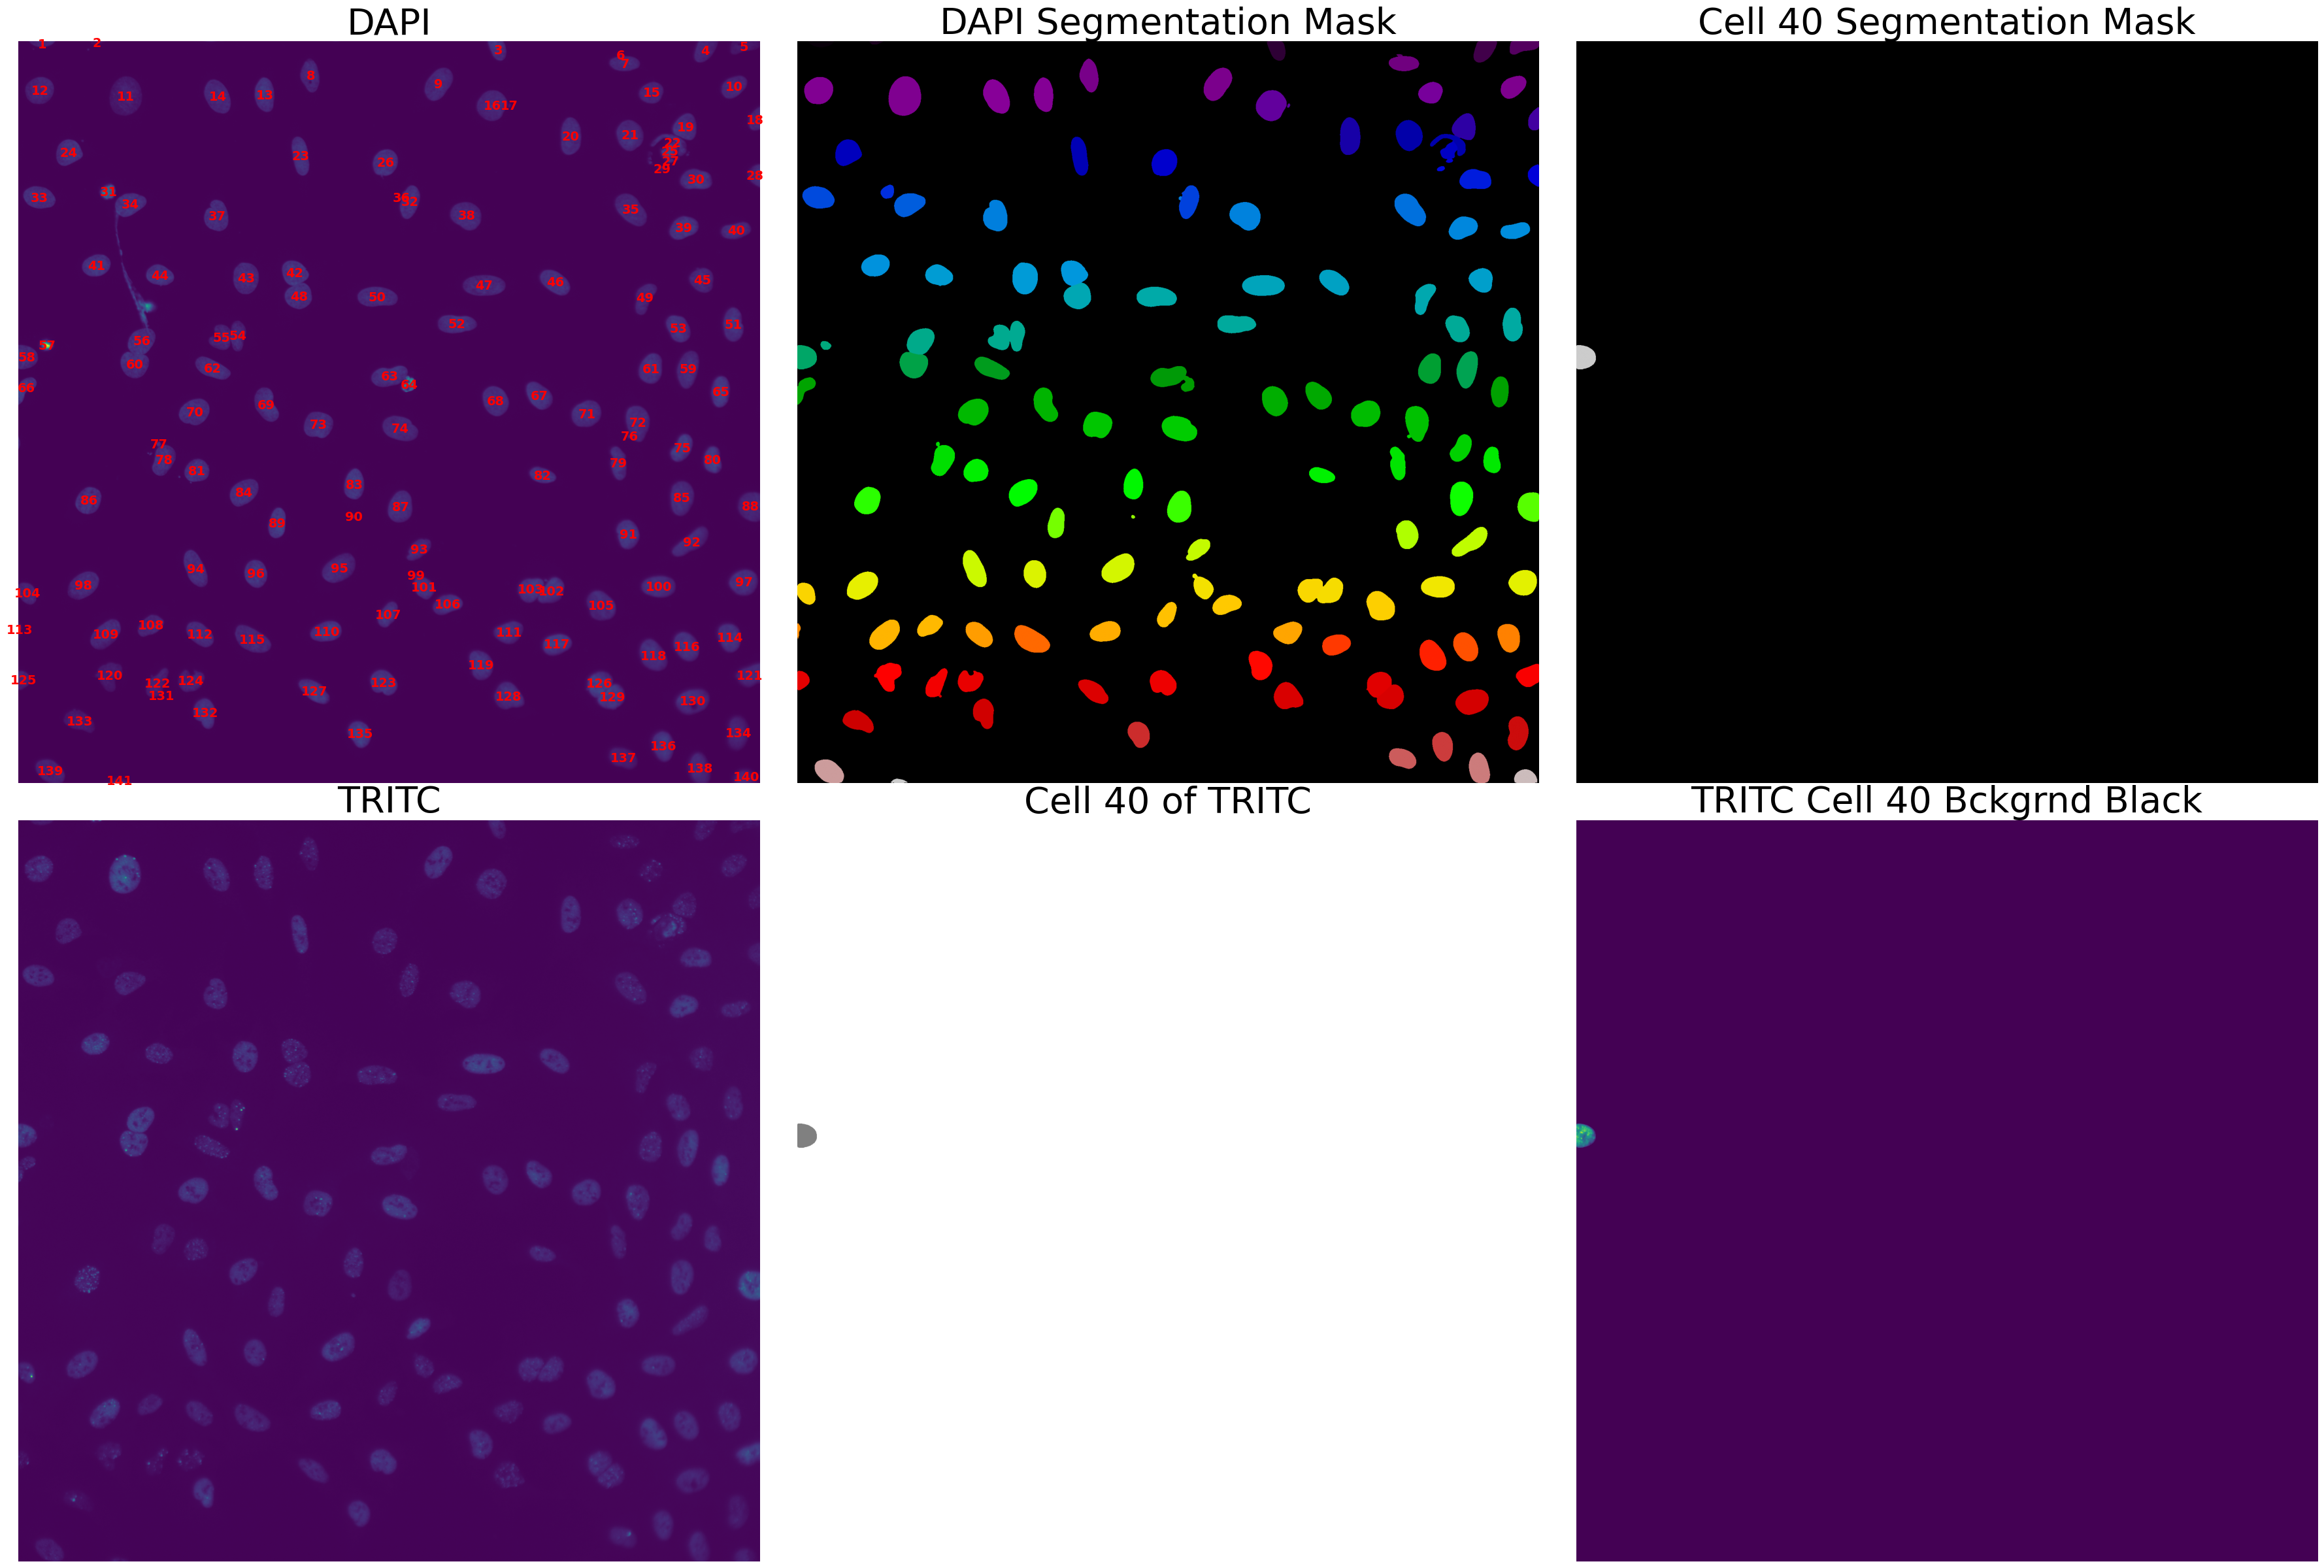

In [40]:
# Plotting Masks
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(36, 24))

# Original DAPI Picture
axes[0,0].imshow(DAPI_pic)

# Adding numbers to the Individual nuclei to identify them easier
nums = regionprops(masks)
for prop in nums:
    #Getting the coordinates of the center of the nuclei
    y, x = prop.centroid  # getting the x and y coordinates
    label = prop.label   # getting the number of the nucleus at that position

    # Adding the text at the location of the centroids
    axes[0,0].text(x, y, str(label), color = 'red', fontsize = 14, ha = 'center', va = 'center', weight = 'bold')

axes[0,0].axis('off')
axes[0,0].set_title('DAPI', fontsize = 40)

# Full Segmentation Mask
axes[0,1].imshow(masks, cmap='nipy_spectral') 
axes[0,1].axis('off')
axes[0,1].set_title('DAPI Segmentation Mask', fontsize = 40)

# Singular Nucleus isolated from Mask
axes[0,2].imshow(masks_reduced, cmap='nipy_spectral')
axes[0,2].axis('off')
axes[0,2].set_title('Cell 40 Segmentation Mask', fontsize = 40)

# Original TRITC Picture
axes[1,0].imshow(TRITC_pic)
axes[1,0].axis('off')
axes[1,0].set_title('TRITC', fontsize = 40)

# Mask overlaying the TRITC Picture
axes[1,1].imshow(masked_TRITC, cmap='nipy_spectral', alpha=0.5)
axes[1,1].axis('off')
axes[1,1].set_title('Cell 40 of TRITC', fontsize = 40)

#show TRITC with applied mask
axes[1,2].imshow(isolated_TRITC)
axes[1,2].axis('off')
axes[1,2].set_title('TRITC Cell 40 Bckgrnd Black', fontsize = 40)

plt.tight_layout()
plt.show()